## lấy data và model 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage import io
import pickle

In [4]:
filename_rfc = "/content/drive/My Drive/Fruit recognition/models/rfc_final_model_acc_0.952"
filename_svc = "/content/drive/My Drive/Fruit recognition/models/svc_final_model_acc_0.941"
rfc_model = pickle.load(open(filename_rfc, 'rb'))
svc_model = pickle.load(open(filename_svc,'rb'))

## tiền xử lý ảnh 

In [5]:
def clustering_image(img):
  #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

In [6]:
def remove_light_color(img, center_color):
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y][0]=0
        img[x][y][1]=0
        img[x][y][2]=0
  return img

In [7]:
def features_section(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):
            
            # Crop ảnh thành các vùng 40 * 40
            section_img = img[y:y+40, x:x+40]
            
            # tính trung bình và độ lệch chuẩn của các giá trị pixel cho từng vùng
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            # tạo features 
            features = np.append(features, [section_mean, section_std])
    
    return features

In [8]:
def create_df_with_one_image(img):
  feature_name = []
  section = 1
  for y in range(0, 200, 40):
      for x in range(0, 200, 40):
          feature_name.append(f"sec{section}_mean")
          feature_name.append(f"sec{section}_std")
          section += 1
  
  all_imgs = np.zeros((1, 50), dtype='uint8')

  name = []
  section_mean = []
  section_std = []

  img_features = features_section(img)
  img_features = img_features.reshape(1, img_features.shape[0])

  all_imgs = np.append(all_imgs, img_features, axis=0)
  all_imgs = all_imgs[1:]

  df = pd.DataFrame(all_imgs, columns= feature_name)
  return df

In [20]:
def create_df_with_one_image1(img):
  columns_name = ['red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']
  red_means = []
  red_stds = []
  green_means = []
  green_stds = []
  blue_means = []
  blue_stds = []

  red_channel = img[:,:,0]
  green_channel = img[:,:,1]
  blue_channel = img[:,:,2]

  red_mean = np.mean(red_channel)
  green_mean = np.mean(green_channel)
  blue_mean = np.mean(blue_channel)
  
  red_std = np.std(red_channel)
  green_std = np.std(green_channel)
  blue_std = np.std(blue_channel)

  red_means.append(red_mean)
  red_stds.append(red_std)
  green_means.append(green_mean)
  green_stds.append(green_std)
  blue_means.append(blue_mean)
  blue_stds.append(blue_std)

      
  data = {'red_mean': red_means, 'red_std': red_stds, 'green_mean': green_means, 
          'green_std': green_stds, 'blue_mean': blue_means, 'blue_std': blue_stds}
  df = pd.DataFrame(data)
  return df

## test thử phân loại trái cây bằng một hình ảnh thực tế  

## nhập đường dẫn image và dự đoán

['cachua']
['cachua']


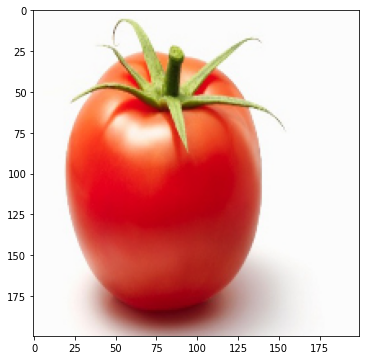

In [39]:
path = 'https://vcdn-vnexpress.vnecdn.net/2017/03/12/cu-qua-trong-tieng-anh6-5904-1489320642.jpg' #@param {type:"string"}
image = io.imread(path)
resized = cv2.resize(image, (200, 200))
clus, center = clustering_image(resized)
img = remove_light_color(clus, center)
edge = cv2.Canny(img, 50, 70)

# tạo dataframe từ ảnh test
data = create_df_with_one_image(edge)
data2 = create_df_with_one_image1(img)

final_data = pd.concat([data2, data],axis=1)


# dự đoán và phân loại 
print (rfc_model.predict(final_data))
print (svc_model.predict(final_data))

figure_size = 6
plt.figure(figsize=(figure_size,figure_size))
plt.imshow(resized)
plt.show()